# CONFORMAL METRIC


In [5]:
import numpy as np
import h5py
from scipy.integrate import cumulative_trapezoid

# ─── 0) CONSTANTS & GUARDS ───────────────────────────────────────────────────
M_sun_cgs       = 1.98847e33        # [g]
GM_c2_cgs       = 1.4766250385e5    # [cm]
rho_cgs_to_geom = GM_c2_cgs**3 / M_sun_cgs
P_cgs_to_geom   = 1.487e-39
TOV_Tiny        = 1e-10             # avoid r=0
DENOM_MIN       = 1e-20             # avoid zero denominators

# ─── 1) SLy PIECEWISE‐POLYTROPE EOS ──────────────────────────────────────────
rho1_cgs   = 10**14.7
rho2_cgs   = 10**15.0
rho_break  = np.array([rho1_cgs, rho2_cgs]) * rho_cgs_to_geom

Gamma      = np.array([3.005, 2.988, 2.851])
K          = np.zeros_like(Gamma)
p1_geom    = 10**34.384 * P_cgs_to_geom
K[0]       = p1_geom / rho_break[0]**Gamma[0]
for i in range(1, len(Gamma)):
    K[i] = K[i-1] * rho_break[i-1]**(Gamma[i-1]-Gamma[i])
P_break = np.array([K[i]*rho_break[i]**Gamma[i] for i in range(len(Gamma)-1)])

def EOS_r2pe(rho):
    seg = np.searchsorted(rho_break, rho, side='right')
    γ, Ki = Gamma[seg], K[seg]
    P   = Ki * rho**γ
    eps = rho + P/(γ-1)
    return P, eps

def EOS_p2erho(P):
    P_clamped = np.maximum(P, 0.0)
    seg       = np.searchsorted(P_break, P_clamped, side='right')
    γ, Ki     = Gamma[seg], K[seg]
    rho       = (P_clamped / Ki)**(1.0/γ)
    eps       = rho + P_clamped/(γ-1)
    return eps, rho

# ─── 2) TOV RHS FUNCTIONS ────────────────────────────────────────────────────
def make_TOV_int(eps_c, p_c):
    def TOV(r, y):
        m_b, m, p, ν = y
        eps, rho_b = EOS_p2erho(p)
        dy = np.empty(4)
        dy[0] = 4*np.pi * rho_b * r**2
        dy[1] = 4*np.pi * eps   * r**2
        dy[2] = -(4*np.pi/3)*(eps_c + p_c)*(eps_c + 3*p_c)*r
        dy[3] =  (4*np.pi/3)*(eps_c + 3*p_c)*r
        return dy
    return TOV

def make_TOV_ext():
    def TOV(r, y):
        m_b, m, p, ν = y
        eps, rho_b   = EOS_p2erho(p)
        fac_sqrt     = np.sqrt(np.maximum(1 - 2*m/r, 0.0))
        denom        = np.maximum(r*(r-2*m), DENOM_MIN)
        dy = np.empty(4)
        dy[0] = 4*np.pi * rho_b * r**2 / fac_sqrt
        dy[1] = 4*np.pi * eps   * r**2
        dy[2] = -(eps + p)*(m + 4*np.pi*r**3*p) / denom
        dy[3] =  (m + 4*np.pi*r**3*p) / denom
        return dy
    return TOV

# ─── 3) RK4 INTEGRATOR WITH SURFACE DETECTION ────────────────────────────────
def solve_ode_rk4(r_array, y0, deriv, stop_when=None):
    N, dt = len(r_array), r_array[1] - r_array[0]
    ys = np.empty((N,4)); ys[0] = y0.copy()
    surf_idx, y_surf = None, None
    y = y0.copy()
    for i in range(1, N):
        r = r_array[i-1]
        k1 = deriv(r, y)
        k2 = deriv(r+dt/2, y+dt/2*k1)
        k3 = deriv(r+dt/2, y+dt/2*k2)
        k4 = deriv(r+dt,   y+dt  *k3)
        y  = y + dt/6*(k1 + 2*k2 + 2*k3 + k4)
        ys[i] = y
        if stop_when and surf_idx is None and stop_when(r_array[i], y):
            surf_idx, y_surf = i, y.copy()
    return r_array, ys, surf_idx, y_surf

found_radius = lambda r, y, pfloor=1e-9: (y[2] <= pfloor).item()

def initial_state(r0, rho0):
    p0, eps0 = EOS_r2pe(rho0)
    m_b0 = 4*np.pi/3 * rho0 * r0**3
    m0   = 4*np.pi/3 * eps0 * r0**3
    return np.array([m_b0, m0, p0, 0.0]), eps0, p0

# ─── 4) SETUP & INITIAL CONDITIONS ──────────────────────────────────────────
rmin, r_int, rmax = TOV_Tiny, 1e-5, 200.0
N_tay, N_int, N_vac = 200, 10000, 100000

r_taylor   = np.linspace(rmin,   r_int,  N_tay)
r_int_full = np.linspace(r_int,   rmax,  N_int)
rho0       = 1.28e-3
sol0, eps_c, p_c = initial_state(rmin, rho0)

# ─── 5) INTEGRATIONS ─────────────────────────────────────────────────────────
# A) Taylor‐series center expansion to r_int
_, y_tay, _, _ = solve_ode_rk4(
    r_taylor, sol0,
    make_TOV_int(eps_c, p_c),
    stop_when=None
)

# B) Full interior solve → find R_surf, M_surf
rb, yb, surf_idx, y_surf = solve_ode_rk4(
    r_int_full, y_tay[-1],
    make_TOV_ext(),
    stop_when=found_radius
)
R_surf, M_surf = rb[surf_idx], y_surf[1]

# C) Vacuum exterior solve from R_surf → rmax
r_vac = np.linspace(R_surf, rmax, N_vac)
rv, yv, _, _ = solve_ode_rk4(
    r_vac, y_surf,
    make_TOV_ext(),
    stop_when=None
)

# ─── 6) STITCH FULL PROFILE ─────────────────────────────────────────────────
r_full = np.concatenate((rb[:surf_idx+1], rv[1:]))
y_full = np.vstack((yb[:surf_idx+1], yv[1:]))

# ─── 7) COMPUTE METRIC POTENTIAL e^{2Λ} (Baumgarte) ─────────────────────────
mask_in  = r_full <= R_surf
mask_out = ~mask_in

# Interior (Eq.21–22)
r_in = r_full[mask_in].copy()
m_in = y_full[mask_in,1]
r_in[0] = TOV_Tiny
sqrt_arg = np.maximum(1 - 2*m_in/r_in, 0.0)
integrand = (1 - np.sqrt(sqrt_arg)) / (r_in * np.sqrt(sqrt_arg))
integrand[0] = 0.0
I = cumulative_trapezoid(integrand, r_in, initial=0.0)
R, M, I_R = r_in[-1], m_in[-1], I[-1]
C = ((np.sqrt(R**2 - 2*M*R) + R - M)/(2*R)) * np.exp(-I_R)
rbar_in = C * r_in * np.exp(I)
exp2lambda_int = (r_in / rbar_in)**2

# Exterior (Eq.15)
r_out = r_full[mask_out]
rbar_ext = 0.5*(np.sqrt(r_out**2 - 2*M_surf*r_out) + r_out - M_surf)
exp2lambda_ext = (1 + M_surf/(2*rbar_ext))**4

# Merge
exp2lambda_full = np.empty_like(r_full)
exp2lambda_full[mask_in]  = exp2lambda_int
exp2lambda_full[mask_out] = exp2lambda_ext

# ─── 8) WRITE HDF5 OUTPUTS ───────────────────────────────────────────────────
with h5py.File("exp2lambda_interior.h5","w") as f_int:
    f_int.create_dataset("r", data=r_in)
    f_int.create_dataset("exp2lambda", data=exp2lambda_int)

with h5py.File("exp2lambda_exterior.h5","w") as f_ext:
    f_ext.create_dataset("r", data=r_out)
    f_ext.create_dataset("exp2lambda", data=exp2lambda_ext)

with h5py.File("exp2lambda_full.h5","w") as f_full:
    f_full.create_dataset("r", data=r_full)
    f_full.create_dataset("exp2lambda", data=exp2lambda_full)

print("✅ Done: interior, exterior, and full profiles written.")


✅ Done: interior, exterior, and full profiles written.


# Physical Quantities and Temporal metric

In [6]:
import numpy as np
import h5py

# ─── 0) UNIT‐CONVERSION CONSTANTS ──────────────────────────────────────────────

# 0.A) 1 M⊙ in grams:
M_sun_cgs = 1.98847e33   # [g]

# 0.B) (G M⊙/c²) in cm:
GM_by_c2_cgs = 1.4766250385e5  # [cm]

# 0.C) Hence (G M⊙/c²)³ in cm³:
length_unit_cubed = GM_by_c2_cgs**3

# 0.D) ⇒ 1 g/cm³ → geometric units = (G M⊙/c²)³ / (M⊙ [g]):
rho_cgs_to_geom = length_unit_cubed / M_sun_cgs  
#                 ≃ 1.619e-18 (dimensionless)

# 0.E) 1 dyn/cm² → geometric units (known factor):
P_cgs_to_geom = 1.487e-39

# ─── 1) PIECEWISE‐POLYTROPE SETUP (SLy) ────────────────────────────────────────

# UNITS CONVERSION
rho1_cgs = 10**14.7    # = 5.0118723363e14 g/cm³
rho2_cgs = 10**15.0    # = 1.0000000000e15 g/cm³


rho_break = np.array([
    rho1_cgs * rho_cgs_to_geom,
    rho2_cgs * rho_cgs_to_geom
])


# Polytropic exponents (SLy):
Gamma = np.array([3.005, 2.988, 2.851])
N_segments = len(Gamma)


log_p1_cgs = 34.384


p1_cgs  = 10**log_p1_cgs              # dyn/cm²
p1_geom = p1_cgs * P_cgs_to_geom      # ≃ 10^34.384 * 1.487e-39 ≃ 3.6e-5

# SOLVE FOR K0 (FIRST K SEGMENT)
rho_b1_geom = rho_break[0]
Gamma0      = Gamma[0]
K0          = p1_geom / (rho_b1_geom**Gamma0)

# BUILD K1 AND K2
K = np.zeros(N_segments)
K[0] = K0
for i in range(1, N_segments):
    rb = rho_break[i-1]
    K[i] = K[i-1] * rb**(Gamma[i-1] - Gamma[i])

# 1.H) Pre‐compute P_break[i] in geometric units if you still need it:
P_break = np.zeros(N_segments - 1)
for i in range(N_segments - 1):
    P_break[i] = K[i] * rho_break[i]**Gamma[i]


# ─── 2) PIECEWISE‐POLYTROPE EOS ROUTINES ─────────────────────────────────────

def EOS_r2pe_piecewise(rho):
    """
    Piecewise‐polytropic EOS: given baryon‐density rho_b, return 
      (pressure, energy_density).
    We assume energy_density = rho_b + P/(Gamma_i - 1) in each segment i.
    """
    # 2.A) Find which segment 'rho' belongs to:
    # If rho <= rho_break[0], segment = 0.
    # If rho_break[0] < rho <= rho_break[1], segment = 1, ...
    # If rho > rho_break[-1], segment = N_segments-1.
    seg = np.searchsorted(rho_break, rho, side='right')
    # seg will be an integer in [0 .. N_segments-1].

    # 2.B) Compute P = K[seg]*rho^Gamma[seg].
    gamma_i = Gamma[seg]
    Ki      = K[seg]
    P       = Ki * rho**gamma_i

    # 2.C) Compute total energy density eps = rho + P/(Gamma_i - 1).
    eps = rho + P/(gamma_i - 1.0)

    return P, eps


def EOS_p2erc_piecewise(P):
    """
    Invert the piecewise EOS: given pressure P, return 
      (energy_density, baryon_density, cs2).
    We first figure out which segment P belongs in (by comparing to P_break[]),
    then invert ρ = (P / K_i)^{1/Gamma_i}, and set
      eps = ρ + P/(Gamma_i - 1).
    Finally the adiabatic sound‐speed squared is cs2 = dP/dε = Gamma_i * P / (ε + P).
    """
    # 2.A) Determine segment by comparing P to P_break:
    # If P <= P_break[0], segment = 0.
    # If P_break[0] < P <= P_break[1], segment = 1, ...
    # If P > P_break[-1], segment = N_segments-1.
    seg = np.searchsorted(P_break, P, side='right')
    # seg ∈ [0 .. N_segments-1].

    gamma_i = Gamma[seg]
    Ki      = K[seg]

    # 2.B) Compute ρ = (P/K_i)^(1/Gamma_i).
    rho = (P / Ki)**(1.0/gamma_i)

    # 2.C) Compute energy density:
    eps = rho + P / (gamma_i - 1.0)

    # 2.D) Adiabatic sound speed squared (assuming simple polytrope):
    #      c_s^2 = dP/dε = (dP/dρ)/(dε/dρ) = [Gamma_i * K_i * ρ^(Γ_i-1)] / [1 + (Gamma_i/(Gamma_i -1)) * K_i * ρ^(Γ_i-1)].
    #      But simpler: c_s^2 = (Gamma_i * P) / (ε + P).
    cs2 = (gamma_i * P) / (eps + P)

    return eps, rho, cs2




# ─── 3) MAKE_TOV AND INTERIOR_TOV DEFINITIONS ─────────────────────────────────

def make_TOV(Kval_unused, Gammaval_unused):
    """
    Outer TOV (for r >= r_int).  We ignore Kval_unused,Gammaval_unused
    because the piecewise‐EOS uses the global arrays above.
    y = [m_b, m, p, nu], t = r
    """
    def TOV(t, y):
        r    = t
        m_b  = y[0]
        m    = y[1]
        p    = y[2]
        nu   = y[3]

        # 3.A) Invert p -> ε, ρ_b, c_s^2 via the piecewise‐EOS:
        ene, rho_b, _ = EOS_p2erc_piecewise(p)

        # 3.B) RHS’s of TOV (baryon‐mass, gravitational mass, pressure, ν):
        dy = np.empty_like(y)
        # baryon mass ODE:
        dy[0] = 4.0*np.pi * rho_b * r**2 / np.sqrt(1.0 - 2.0*m/r)
        # gravitational mass ODE:
        dy[1] = 4.0*np.pi * ene   * r**2
        # pressure ODE:
        dy[2] = -(ene + p)*(m + 4.0*np.pi * r**3 * p) / (r * (r - 2.0*m))
        # metric potential ODE (dν/dr):
        dy[3] = (m + 4.0*np.pi * r**3 * p) / (r * (r - 2.0*m))
        return dy
    return TOV


def make_TOV_int(Kval_unused, Gammaval_unused):
    """
    Interior TOV (for r <= r_int), using center expansion.
    We again ignore Kval_unused,Gammaval_unused.
    """
    def TOV(t, y):
        r    = t
        m_b  = y[0]
        m    = y[1]
        p    = y[2]
        nu   = y[3]

        # 3.C) Invert p -> ε, ρ_b via piecewise‐EOS:
        ene, rho_b, _ = EOS_p2erc_piecewise(p)

        # 3.D) Compute central values for small‐r expansions:
        #      We assume rho_0, p_0, ε_0 are already defined in outer scope.
        p_c   = K0 * rho_0**Gamma[0]
        ene_c = rho_0 + p_c/(Gamma[0] - 1.0)

        dy = np.empty_like(y)
        # baryon mass ODE (interior):
        dy[0] = 4.0*np.pi * rho_b * r**2
        # gravitational mass ODE (interior):
        dy[1] = 4.0*np.pi * ene   * r**2
        # “proto‐pressure” ODE (Taylor near center):
        dy[2] = -(4.0*np.pi/3.0) * (ene_c + p_c)*(ene_c + 3.0*p_c)*r
        # “proto‐ν” ODE (Taylor near center):
        dy[3] = (4.0*np.pi/3.0) * (ene_c + 3.0*p_c)*r
        return dy
    return TOV


# stop_when: return a Python bool (True when p <= pfloor)
found_radius = lambda t, y, pfloor=1e-9: (y[2] <= pfloor).item()


# ─── 4) INITIAL CONDITIONS & RK4 INTEGRATOR ─────────────────────────────────

def inital_TOV(rho_center, K_unused, Gamma_unused, verbose=True):
    """
    Initialize TOV at r = rmin using central baryon‐density rho_center.
    Returns y0 = [m_b0, m0, p0, nu0].
    """
    # 4.A) Find p0, ε0 from central rho_center:
    p0, eps0 = EOS_r2pe_piecewise(rho_center)

    if verbose:
        print("Central baryon-density  ρ₀ =", rho_center)
        print("Central Pressure        p₀ =", p0)
        print("Central energy-density  ε₀ =", eps0)

    m_b0 = (4.0/3.0) * np.pi * rho_center * (rmin**3)
    m0   = (4.0/3.0) * np.pi * eps0      * (rmin**3)
    nu0  = 0.0   # can choose zero at rmin
    return np.array([m_b0, m0, p0, nu0])


def solve_ode_rk4(t_array, y0, dydt_fun, stop_when=None, verbose=False):
    """
    Classic RK4 integrator over t_array.
    y0 is a 1D vector of length 4.
    If stop_when(t, y) ever returns True, break and return (ts, ys) up to that point.
    """
    N  = len(t_array)
    dt = t_array[1] - t_array[0]

    y   = y0.copy()
    ys  = [y.copy()]
    ts  = [t_array[0]]

    for i in range(1, N):
        t = t_array[i-1]
        k1 = dydt_fun(t, y)
        k2 = dydt_fun(t + dt/2, y + dt/2 * k1)
        k3 = dydt_fun(t + dt/2, y + dt/2 * k2)
        k4 = dydt_fun(t + dt,     y + dt   * k3)

        y = y + (dt/6.0) * (k1 + 2.0*k2 + 2.0*k3 + k4)

        ys.append(y.copy())
        ts.append(t_array[i])

        if stop_when and stop_when(t_array[i], y):
            print(50*"*" + f"\nSurface found at r = {t_array[i]:.6f}\n" + 50*"*")
            return np.array(ts), np.array(ys)

        if verbose:
            print(f"r = {t_array[i]:.4f}, y = {y}")

    print("No surface reached by r_max.")
    return np.array(ts), np.array(ys)


# Definimos la ecuación para el potencial nu

def nu_TOV(r_full, pressure_vals, ene_vals, ys_full, rspanext, ene_c, p_c):
           
    N_full = len(r_full)
    N_ext  = len(rspanext)

    m_vals = ys_full[:, 1]                   # masa m(r)
    dPdr   = np.empty(N_full)
    dnudr  = np.empty(N_full)

    # Recorremos del borde (-1) hacia el centro (0)
    for k in range(N_full - 1, -1, -1):
        r   = r_full[k]
        P   = pressure_vals[k]
        eps = ene_vals[k]
        m   = m_vals[k]
        dnudr[k] = (m + 4.0*np.pi*r**3*P)/(r * (r - 2.0*m))

    return dnudr


# ------------------------------------------------------------------
# 2.2)  Integración de ν(r) desde r_max → r_min
# ------------------------------------------------------------------
def solve_nu(dnudr, nu_ini, drint, drext, r_full, rspanext):
    N_full = len(r_full)
    N_ext  = len(rspanext)

    nu_sol       = np.empty(N_full)
    nu_sol[-1]   = nu_ini        # condición en la superficie

    # Recorremos del borde (-1) hacia el centro
    for k in range(N_full - 2, -1, -1):
        step = drext if (N_full - 1 - k) < N_ext else drint
        nu_sol[k] = nu_sol[k + 1] - dnudr[k + 1] * step

    return nu_sol

# ─── 5) USER‐DEFINED INPUT & GRIDS ────────────────────────────────────────────

# 5.A) Radial grid parameters:
rmin, rint, rmax = 0, 0.00001, 200.0  
#     start at a tiny rmin to avoid division by zero, integrate interior to rint,
#     then exterior from rint to rmax.

Nint = 100     # # RK4-steps from rmin to rint
Next = 100000    # # RK4-steps from rint to rmax

rspanint = np.linspace(rmin, rint, Nint)
rspanext = np.linspace(rint, rmax, Next)

drint = rspanint[1]-rspanint[0]
drext = rspanext[1]-rspanext[0]

# 5.B) Central baryon‐density (in same units as rho_break!)
rho_0 = 1.28e-3  

# 5.C) EOS parameters (piecewise polytrope) have already been set above:
#       -   rho_break[], Gamma[], K[].

# 5.D) Build TOV RHS functions:
TOVint = make_TOV_int(K0, Gamma[0])   # interior
TOVext = make_TOV(K0,    Gamma[0])    # exterior


# ─── 6) INTEGRATE TOV ─────────────────────────────────────────────────────────

# 6.A) Initial Y at r = rmin:
sol0 = inital_TOV(rho_0, K0, Gamma[0], verbose=True)

# 6.B) Interior: integrate from rmin → rint
tint, solint = solve_ode_rk4(rspanint, sol0, TOVint, stop_when=found_radius, verbose=False)

# 6.C) Grab the *last* state‐vector at r = rint:
y_at_rint = solint[-1]  # shape = (4,)

# 6.D) Exterior: integrate from rint → rmax
text, solext = solve_ode_rk4(rspanext, y_at_rint, TOVext, stop_when=found_radius, verbose=False)

# 6.E) Stellar radius & masses:
R_surface_geom = text[-1]           # in geometric length‐units
R_km           = R_surface_geom * 1.477   # convert to km (approx. G M⊙/c² factor)
M_bar          = solext[-1, 0]      # baryon mass at surface
M_grav         = solext[-1, 1]      # gravitational mass at surface
p_surf         = solext[-1, 2]      # should be ≲ pfloor

print("************************************************")
print(f"Surface pressure (should be small) = {p_surf:.3e}")
print(f"Stellar Radius R                  = {R_km:.6f}  km")
print(f"Gravitational Mass M (geom)       = {M_grav:.6f}")
print(f"Baryon Mass M_b                   = {M_bar:.6f}")
print("************************************************")


# ─── 7) BUILD FULL PROFILE & WRITE HDF5 ───────────────────────────────────────

# 7.A) Concatenate interior & exterior arrays (skip duplicate r = rint)
r_full  = np.concatenate((tint, text))         # shape = (len(tint)+len(text),)
ys_full = np.vstack((solint, solext))          # shape = (len(tint)+len(text), 4)

# 7.B) Extract pressure at each r:
pressure_vals = ys_full[:, 2]  # P(r_i)

# 7.C) Compute ε(r) and enthalpy h(r) at each point:
ene_vals     = np.zeros_like(pressure_vals)
rho_vals     = np.zeros_like(pressure_vals)
cs2_vals     = np.zeros_like(pressure_vals)

for i, pval in enumerate(pressure_vals):
    eps_i, rho_i, cs2_i = EOS_p2erc_piecewise(pval)
    ene_vals[i] = eps_i
    rho_vals[i] = rho_i
    cs2_vals[i] = cs2_i

#    enthalpy h = (ε + P)/ρ_b
enthalpy_vals = (ene_vals + pressure_vals) / rho_vals



#  Evolution of the nu potential
ene_central = ene_vals[0]
p_central = pressure_vals[0]
nu_ini = 1/2*np.log(1-2*M_bar/R_surface_geom)
dnudr = nu_TOV(r_full, pressure_vals, ene_vals, ys_full, rspanext, ene_central, p_central)
solnu = solve_nu(dnudr, nu_ini, drint, drext, r_full, rspanext)





# 1) Make sure we mask the SAME r_full used for solnu
mask_int_nu = (r_full <= R_surface_geom)   # r_full and solnu must have the same length

# 2) Extract the interior ν
nu_int = solnu[mask_int_nu]

# 3) Build the exterior grid and νout
r_out = np.linspace(R_surface_geom, rmax, Next)
arg   = np.maximum(1 - 2.0*M_bar/r_out, 1e-20)
nuout = 0.5 * np.log(arg)

# 4) Stitch, dropping the first exterior point
nu_full = np.concatenate([ nu_int, nuout[1:] ])

# 5) (Optional) stitch the radii in the same way
r_full_ext = np.concatenate([ r_full[mask_int_nu], r_out[1:] ])


# 7.D) Write to HDF5
with h5py.File("tov_piecewise_output.h5", "w") as f:
    f.create_dataset("radius",         data=r_full)
    f.create_dataset("radius_ext",     data=r_full_ext)
    f.create_dataset("pressure",       data=pressure_vals)
    f.create_dataset("energy_density", data=ene_vals)
    f.create_dataset("baryon_density", data=rho_vals)
    f.create_dataset("enthalpy",       data=enthalpy_vals)
    f.create_dataset("cs2",            data=cs2_vals)
    f.create_dataset("Gamma_segments", data=Gamma)
    f.create_dataset("rho_break",      data=rho_break)
    f.create_dataset("K_segments",     data=K)
    f.create_dataset("Nu_pot",         data=nu_full)

print("✅ Piecewise‐polytrope TOV data written to 'tov_piecewise_output.h5'")





Central baryon-density  ρ₀ = 0.00128
Central Pressure        p₀ = 0.00014050472601783307
Central energy-density  ε₀ = 0.0013506764215381454
No surface reached by r_max.
**************************************************
Surface found at r = 7.066080
**************************************************
************************************************
Surface pressure (should be small) = 7.503e-10
Stellar Radius R                  = 10.436601  km
Gravitational Mass M (geom)       = 1.038619
Baryon Mass M_b                   = 1.135757
************************************************
✅ Piecewise‐polytrope TOV data written to 'tov_piecewise_output.h5'


C:\Users\Ignacio\AppData\Local\Temp\ipykernel_14828\972958188.py:268: RuntimeWarning: invalid value encountered in scalar divide
  dnudr[k] = (m + 4.0*np.pi*r**3*P)/(r * (r - 2.0*m))


# Plotting

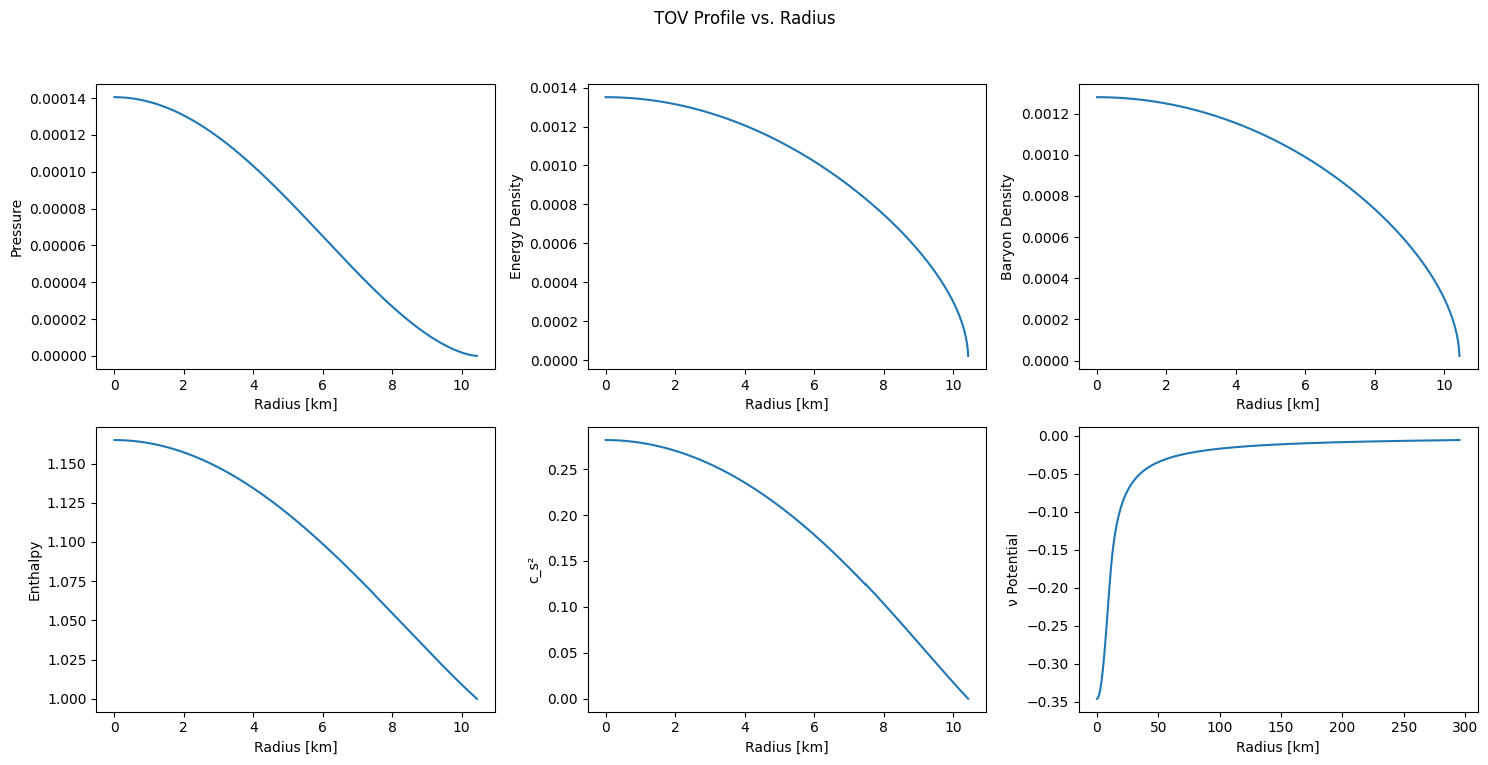

In [7]:
import h5py
import matplotlib.pyplot as plt

# Open the HDF5 file
with h5py.File("tov_piecewise_output.h5", "r") as f:
    # geometric→km conversion
    km = 1.477
    r       = km * f["radius"][:]       # interior radius grid
    rfull   = km * f["radius_ext"][:]   # exterior radius grid for ν
    P       = f["pressure"][:]
    eps     = f["energy_density"][:]
    rho     = f["baryon_density"][:]
    h       = f["enthalpy"][:]
    cs2     = f["cs2"][:]
    nu      = f["Nu_pot"][:]            # interior ν(r)

# Set up 2×3 subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

profiles = [
    (r,   P,   "Pressure"),
    (r,   eps, "Energy Density"),
    (r,   rho, "Baryon Density"),
    (r,   h,   "Enthalpy"),
    (r,   cs2, "c_s²"),
    (rfull, nu,  "ν Potential")       # use rfull here
]

for ax, (rad, data, label) in zip(axes, profiles):
    ax.plot(rad, data)
    ax.set_xlabel("Radius [km]")
    ax.set_ylabel(label)

fig.suptitle("TOV Profile vs. Radius")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


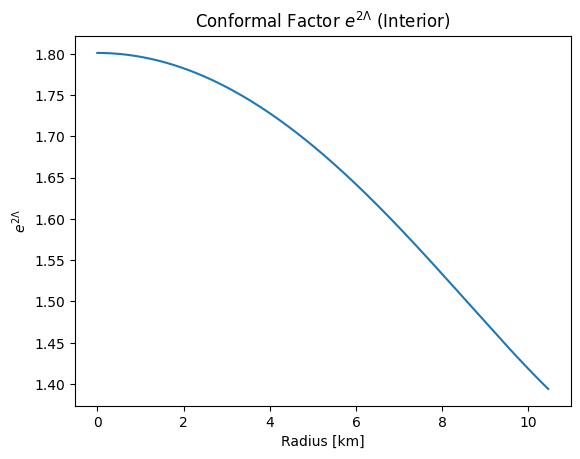

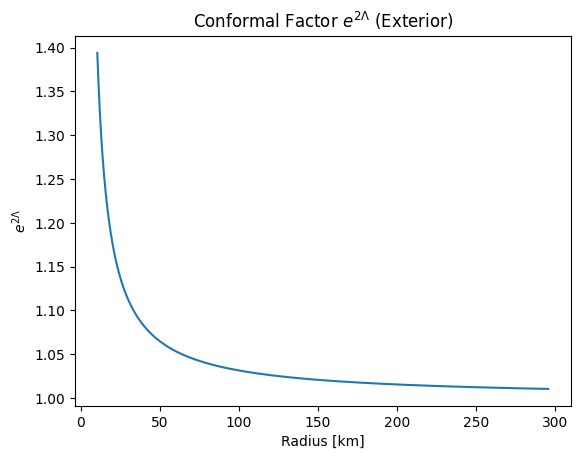

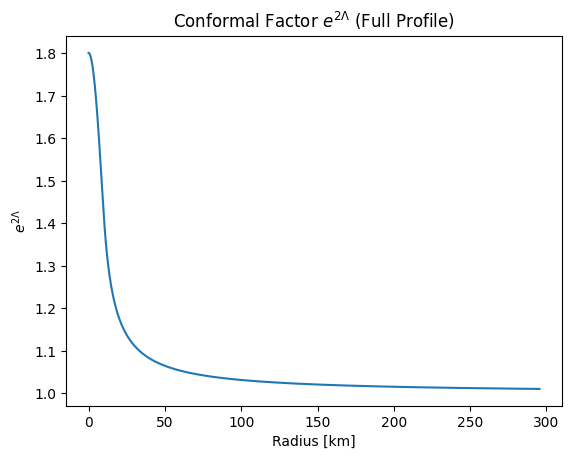

In [8]:
import h5py
import matplotlib.pyplot as plt

# 1) Load interior metric potential
with h5py.File("exp2lambda_interior.h5", "r") as f_int:
    r_in = 1.477*f_int["r"][:]
    exp2lambda_int = f_int["exp2lambda"][:]

# 2) Load exterior metric potential
with h5py.File("exp2lambda_exterior.h5", "r") as f_ext:
    r_out = 1.477*f_ext["r"][:]
    exp2lambda_ext = f_ext["exp2lambda"][:]

# 3) Load full-profile metric potential
with h5py.File("exp2lambda_full.h5", "r") as f_full:
    r_full = 1.477*f_full["r"][:]
    exp2lambda_full = f_full["exp2lambda"][:]

# 4) Plot interior
plt.figure()
plt.plot(r_in, exp2lambda_int)
plt.title("Conformal Factor $e^{2\\Lambda}$ (Interior)")
plt.xlabel("Radius [km]")
plt.ylabel("$e^{2\\Lambda}$")
plt.show()

# 5) Plot exterior
plt.figure()
plt.plot(r_out, exp2lambda_ext)
plt.title("Conformal Factor $e^{2\\Lambda}$ (Exterior)")
plt.xlabel("Radius [km]")
plt.ylabel("$e^{2\\Lambda}$")
plt.show()

# 6) Plot full profile
plt.figure()
plt.plot(r_full, exp2lambda_full)
plt.title("Conformal Factor $e^{2\\Lambda}$ (Full Profile)")
plt.xlabel("Radius [km]")
plt.ylabel("$e^{2\\Lambda}$")
plt.show()
